In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from torch.nn.parameter import Parameter


def conv_weight(in_planes, planes, kernel_size=3, stride=1, padding=0, bias=False, transpose=False):
    " init convolutions parameters, necessary due to code architecture "
    if transpose:
        params = nn.ConvTranspose2d(in_planes, planes, kernel_size=kernel_size, stride=stride,
                                    padding=padding, bias=bias).weight.data
    else:
        params = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride,
                           padding=padding, bias=bias).weight.data
    return params


class Complex(nn.Module):
    def __init__(self, real=None, imag=None):
        super(Complex, self).__init__()
        self.real = real
        if imag is None and real is not None:
            self.imag = torch.zeros_like(self.real)
        elif imag is None and real is None:
            self.imag = None
        else:
            self.imag = imag
        if self.real is not None:
            self.shape = self.real.shape
            self.size = self.real.size
        else:
            self.shape = None
            self.size = None

    def mag(self):
        return torch.sqrt(self.real ** 2 + self.imag ** 2)

    def phase(self):
        return torch.atan2(self.imag, self.real)

    def from_polar(self, mag, phase):
        self.real = mag * torch.cos(phase)
        self.imag = mag * torch.sin(phase)
        return

    def view(self, *params):
        return Complex(self.real.view(*params), self.imag.view(*params))

    def __repr__(self):
        # print(f'Complex Variable containing:\nreal:\n{self.real}imaginary:\n{self.imag}') <- does'nt work
        return ''


class C_convtranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(C_convtranspose2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.weight_real = nn.Parameter(
            conv_weight(in_channels, out_channels, kernel_size, stride, padding, transpose=True), requires_grad=True)
        self.weight_imag = nn.Parameter(
            conv_weight(in_channels, out_channels, kernel_size, stride, padding, transpose=True), requires_grad=True)

    def forward(self, complex):
        x_ = F.conv_transpose2d(complex.real, self.weight_real, stride=self.stride, padding=self.padding) - \
             F.conv_transpose2d(complex.imag, self.weight_imag, stride=self.stride, padding=self.padding)
        y_ = F.conv_transpose2d(complex.imag, self.weight_real, stride=self.stride, padding=self.padding) + \
             F.conv_transpose2d(complex.real, self.weight_imag, stride=self.stride, padding=self.padding)
        return Complex(x_, y_)


class C_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(C_conv2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.weight_real = nn.Parameter(conv_weight(in_channels, out_channels, kernel_size, stride, padding),
                                        requires_grad=True)
        self.weight_imag = nn.Parameter(conv_weight(in_channels, out_channels, kernel_size, stride, padding),
                                        requires_grad=True)

    def forward(self, complex):
        x_ = F.conv2d(complex.real, self.weight_real, stride=self.stride, padding=self.padding) - \
             F.conv2d(complex.imag, self.weight_imag, stride=self.stride, padding=self.padding)
        y_ = F.conv2d(complex.imag, self.weight_real, stride=self.stride, padding=self.padding) + \
             F.conv2d(complex.real, self.weight_imag, stride=self.stride, padding=self.padding)

        return Complex(x_, y_)


class C_BatchNorm2d(nn.Module):
    def __init__(self, num_features, affine=True, epsilon=1e-4, check=False, \
                 momentum=0.1, track_running_stats=True):
        super(C_BatchNorm2d, self).__init__()
        self.check = check
        self.affine = affine
        self.epsilon = epsilon
        self.momentum = momentum
        self.track_running_stats = track_running_stats

        if self.affine:
            self.bias_real = Parameter(torch.Tensor(num_features), requires_grad=True)
            self.bias_imag = Parameter(torch.Tensor(num_features), requires_grad=True)

            self.gamma_rr = Parameter(torch.Tensor(num_features), requires_grad=True)
            self.gamma_ri = Parameter(torch.Tensor(num_features), requires_grad=True)
            self.gamma_ii = Parameter(torch.Tensor(num_features), requires_grad=True)
        else:
            self.register_parameter('bias_real', None)
            self.register_parameter('bias_imag', None)

            self.register_parameter('gamma_rr', None)
            self.register_parameter('gamma_ri', None)
            self.register_parameter('gamma_ii', None)

        if self.track_running_stats:
            self.register_buffer('running_mean_real', torch.zeros(num_features))
            self.register_buffer('running_mean_imag', torch.zeros(num_features))

            self.register_buffer('running_Vrr', torch.ones(num_features) / float(np.sqrt(2.0)))
            self.register_buffer('running_Vii', torch.ones(num_features) / float(np.sqrt(2.0)))
            self.register_buffer('running_Vri', torch.zeros(num_features))

            self.register_buffer('num_batches_tracked', torch.zeros(1))
        else:
            self.register_buffer('running_mean_real', None)
            self.register_buffer('running_mean_imag', None)

            self.register_buffer('running_Vrr', None)
            self.register_buffer('running_Vii', None)
            self.register_buffer('running_Vri', None)

            self.register_buffer('num_batches_tracked', None)

        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean_real.zero_()
            self.running_mean_imag.zero_()

            self.running_Vrr.fill_(1.0 / float(np.sqrt(2.0)))
            self.running_Vii.fill_(1.0 / float(np.sqrt(2.0)))
            self.running_Vri.zero_()

            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            nn.init.constant(self.bias_real.data, 0.0)
            nn.init.constant(self.bias_imag.data, 0.0)

            nn.init.constant(self.gamma_rr.data, float(np.sqrt(0.5)))
            nn.init.constant(self.gamma_ri.data, float(np.sqrt(0.5)))
            nn.init.constant(self.gamma_ii.data, float(np.sqrt(0.5)))

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

    def forward(self, complex):
        real = complex.real
        imag = complex.imag
        if self.training:
            def mean_along_multiple_dimensions(tensor, dims):
                for i, dim in enumerate(np.sort(dims)):
                    tensor = torch.mean(tensor, dim=int(dim - i))
                return tensor

            real_means = mean_along_multiple_dimensions(real, dims=[0, 2, 3])
            imag_means = mean_along_multiple_dimensions(imag, dims=[0, 2, 3])

            self.running_mean_real = self.running_mean_real * self.momentum + (1.0 - self.momentum) * real_means.data
            self.running_mean_imag = self.running_mean_imag * self.momentum + (1.0 - self.momentum) * imag_means.data

            real_means = real_means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            imag_means = imag_means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            real_centered = real - real_means
            imag_centered = imag - imag_means

            def sum_along_multiple_dimensions(tensor, dims):
                for i, dim in enumerate(np.sort(dims)):
                    tensor = torch.sum(tensor, dim=int(dim - i))
                return tensor

            Vrr = mean_along_multiple_dimensions(real_centered * real_centered, dims=[0, 2, 3]) + self.epsilon
            Vri = mean_along_multiple_dimensions(real_centered * imag_centered, dims=[0, 2, 3])
            Vii = mean_along_multiple_dimensions(imag_centered * imag_centered, dims=[0, 2, 3]) + self.epsilon

            self.running_Vrr = self.running_Vrr * self.momentum + (1.0 - self.momentum) * Vrr.data
            self.running_Vri = self.running_Vri * self.momentum + (1.0 - self.momentum) * Vri.data
            self.running_Vii = self.running_Vii * self.momentum + (1.0 - self.momentum) * Vii.data

            self.num_batches_tracked += 1


        else:
            real_means = Variable(self.running_mean_real.unsqueeze(0).unsqueeze(-1).unsqueeze(-1), requires_grad=False)
            imag_means = Variable(self.running_mean_imag.unsqueeze(0).unsqueeze(-1).unsqueeze(-1), requires_grad=False)

            Vrr = Variable(self.running_Vrr, requires_grad=False)
            Vri = Variable(self.running_Vri, requires_grad=False)
            Vii = Variable(self.running_Vii, requires_grad=False)

            real_centered = real - real_means
            imag_centered = imag - imag_means

        tau = Vrr + Vii
        delta = (Vrr * Vii) - (Vri ** 2)
        s = torch.sqrt(delta)
        t = torch.sqrt(tau + 2 * s)

        inverse_st = 1.0 / (float(np.sqrt(2.0)) * s * t)
        Wrr = (Vii + s) * inverse_st
        Wii = (Vrr + s) * inverse_st
        Wri = -Vri * inverse_st

        Wrr = Wrr.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        Wri = Wri.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        Wii = Wii.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        real_normed = Wrr * real_centered + Wri * imag_centered
        imag_normed = Wri * real_centered + Wii * imag_centered

        if self.check:
            result_real_means = mean_along_multiple_dimensions(real_normed, dims=[0, 2, 3])
            result_imag_means = mean_along_multiple_dimensions(imag_normed, dims=[0, 2, 3])

            print("real part of result means: ", result_real_means)
            print("imag part of result means: ", result_imag_means)

            Vrr = mean_along_multiple_dimensions(real_normed * real_normed, dims=[0, 2, 3]) + self.epsilon
            Vri = mean_along_multiple_dimensions(real_normed * imag_normed, dims=[0, 2, 3])
            Vii = mean_along_multiple_dimensions(imag_normed * imag_normed, dims=[0, 2, 3]) + self.epsilon

            print('covariance: ', Vrr + Vii)

            print('real part of relation: ', Vrr - Vii)
            print('iamg part of relation: ', 2 * Vri)

        gamma_rr = self.gamma_rr.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        gamma_ri = self.gamma_ri.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        gamma_ii = self.gamma_ii.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        bias_real = self.bias_real.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        bias_imag = self.bias_imag.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        ans_real = real_normed * gamma_rr + imag_normed * gamma_ri + bias_real
        ans_imag = real_normed * gamma_ri + imag_normed * gamma_ii + bias_imag
        # print(ans_real.shape)
        # print(ans_imag.shape)
        return Complex(ans_real, ans_imag)


class C_Linear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(C_Linear, self).__init__()
        self.weight_real = nn.Parameter(nn.Linear(in_dim, out_dim).weight.data, requires_grad=True)
        self.weight_imag = nn.Parameter(nn.Linear(in_dim, out_dim).weight.data, requires_grad=True)

    def forward(self, complex):
        x_ = F.linear(complex.real, self.weight_real) - F.linear(complex.imag, self.weight_imag)
        y_ = F.linear(complex.real, self.weight_imag) + F.linear(complex.imag, self.weight_real)
        return Complex(x_, y_)


class C_ReLU(nn.Module):
    def __init__(self):
        super(C_ReLU, self).__init__()

    def forward(self, complex):
        return Complex(F.relu(complex.real), F.relu(complex.imag))


class C_LeakyReLU(nn.Module):
    def __init__(self, alpha=0.001):
        super(C_LeakyReLU, self).__init__()
        self.alpha = alpha

    def forward(self, complex):
        return Complex(F.leaky_relu(complex.real, self.alpha), F.leaky_relu(complex.imag, self.alpha))


class Mod_ReLU(nn.Module):
    def __init__(self, channels):
        super(Mod_ReLU, self).__init__()
        self.b = nn.Parameter(torch.FloatTensor(channels).fill_(0), requires_grad=True)

    def forward(self, complex):
        mag = complex.mag()
        if len(mag.shape) > 2:
            mag = F.relu(mag + self.b[None, :, None, None])
        else:
            mag = F.relu(mag + self.b[None, :])
        res = Complex()
        res.from_polar(mag, complex.phase())
        return res


def complex_weight_init(m):
    classname = m.__class__.__name__
    if classname.find('C_Linear') != -1:
        # real weigths
        fan_in_real, fan_out_real = nn.init._calculate_fan_in_and_fan_out(m.weight_real.data)
        s_real = 1. / (fan_in_real + fan_out_real)  # glorot or xavier criterion
        rng_real = np.random.RandomState(999)
        modulus_real = rng_real.rayleigh(scale=s_real, size=m.weight_real.data.shape)
        phase_real = rng_real.uniform(low=-np.pi, high=np.pi, size=m.weight_real.data.shape)
        weight_real = torch.from_numpy(modulus_real) * torch.cos(torch.from_numpy(phase_real))
        # imag weights
        fan_in_imag, fan_out_imag = nn.init._calculate_fan_in_and_fan_out(m.weight_imag.data)
        s_imag = 1. / (fan_in_imag + fan_out_imag)  # glorot or xavier criterion
        rng_imag = np.random.RandomState(999)
        modulus_imag = rng_imag.rayleigh(scale=s_imag, size=m.weight_imag.data.shape)
        phase_imag = rng_imag.uniform(low=-np.pi, high=np.pi, size=m.weight_imag.data.shape)
        weight_imag = torch.from_numpy(modulus_imag) * torch.cos(torch.from_numpy(phase_imag))

    if classname.find('C_conv2d') != -1:
        # real weigths
        fan_in_real, fan_out_real = nn.init._calculate_fan_in_and_fan_out(m.weight_real.data)
        s_real = 1. / (fan_in_real + fan_out_real)  # glorot or xavier criterion
        rng_real = np.random.RandomState(999)
        modulus_real = rng_real.rayleigh(scale=s_real, size=m.weight_real.data.shape)
        phase_real = rng_real.uniform(low=-np.pi, high=np.pi, size=m.weight_real.data.shape)
        weight_real = torch.from_numpy(modulus_real) * torch.cos(torch.from_numpy(phase_real))
        # imag weights
        fan_in_imag, fan_out_imag = nn.init._calculate_fan_in_and_fan_out(m.weight_imag.data)
        s_imag = 1. / (fan_in_imag + fan_out_imag)  # glorot or xavier criterion
        rng_imag = np.random.RandomState(999)
        modulus_imag = rng_imag.rayleigh(scale=s_imag, size=m.weight_imag.data.shape)
        phase_imag = rng_imag.uniform(low=-np.pi, high=np.pi, size=m.weight_imag.data.shape)
        weight_imag = torch.from_numpy(modulus_imag) * torch.cos(torch.from_numpy(phase_imag))

    if classname.find('C_BatchNorm2d') != -1:
        # real weigths
        fan_in_real, fan_out_real = nn.init._calculate_fan_in_and_fan_out(m.weight_real.data)
        s_real = 1. / (fan_in_real + fan_out_real)  # glorot or xavier criterion
        rng_real = np.random.RandomState(999)
        modulus_real = rng_real.rayleigh(scale=s_real, size=m.weight_real.data.shape)
        phase_real = rng_real.uniform(low=-np.pi, high=np.pi, size=m.weight_real.data.shape)
        weight_real = torch.from_numpy(modulus_real) * torch.cos(torch.from_numpy(phase_real))
        # imag weights
        fan_in_imag, fan_out_imag = nn.init._calculate_fan_in_and_fan_out(m.weight_imag.data)
        s_imag = 1. / (fan_in_imag + fan_out_imag)  # glorot or xavier criterion
        rng_imag = np.random.RandomState(999)
        modulus_imag = rng_imag.rayleigh(scale=s_imag, size=m.weight_imag.data.shape)
        phase_imag = rng_imag.uniform(low=-np.pi, high=np.pi, size=m.weight_imag.data.shape)
        weight_imag = torch.from_numpy(modulus_imag) * torch.cos(torch.from_numpy(phase_imag))


class Sample(nn.Module):
    """
    Foo model
    """

    def __init__(self):
        super(Sample, self).__init__()
        self.conv1 = C_convtranspose2d(3, 3, 3, 1, 1)
        self.relu = C_ReLU()
        self.conv2 = C_convtranspose2d(3, 3, 3, 1, 1)
        self.mod_relu = Mod_ReLU(3)
        self.conv3 = C_convtranspose2d(3, 3, 3, 1, 1)

    def forward(self, complex):
        complex = self.conv1(complex)
        complex = self.relu(complex)
        complex = self.conv2(complex)
        complex = self.mod_relu(complex)
        return self.conv3(complex)


def test_1():
    from torch import optim
    a = Variable(torch.rand(2, 3, 5, 5), requires_grad=True)
    b = Variable(torch.rand(2, 3, 5, 5), requires_grad=True)
    complex = Complex(a, b)
    conv1 = C_conv2d(3, 3, 3, 1, 1)
    complex_weight_init(conv1)  # conv layer weight init.
    prev = list(conv1.parameters())[0].clone()
    res = conv1(complex)
    optimizer = optim.Adam(conv1.parameters(), 0.1)
    foo = Variable(torch.rand(2, 3, 5, 5))
    for i in range(10):
        complex_res = conv1(complex)
        loss = F.mse_loss(complex_res.mag(), foo)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_2():
    from torch import optim
    import numpy as np
    a = torch.rand(2, 3, 5, 5)
    b = torch.rand(2, 3, 5, 5)
    complex = Complex(a, b)
    model = Sample()
    model.apply(complex_weight_init)  # apply complex weights initialization
    parameters_start = [p.clone() for p in model.parameters()]
    prev = list(model.parameters())[0].clone()
    optimizer = optim.Adam(model.parameters(), 0.1)
    foo = Variable(torch.rand(2, 3, 5, 5))
    for i in range(10):
        complex_res = model(complex)
        loss = F.mse_loss(complex_res.mag(), foo)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    for l1, l2 in zip(parameters_start, list(model.parameters())):
        assert np.array_equal(l1.cpu().data.numpy(), l2.cpu().data.numpy()) == False


In [9]:
import torch.nn as nn
import torch


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - in_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    """

    def __init__(self,input_channel, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(input_channel, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return x


In [15]:
import torch.utils.data as data
import numpy as np
import torch
import random
import pickle
import os
dataset={"Bay":["Bay_data.pt","Bay_real_data.pt","Bay_imag_data.pt","Bay_label_5.pt"],
         "fle":["fle_data.pt","fle_real_data.pt","fle_imag_data.pt","fle_label_11.pt"]}
DASETDIR="./input/dataset"
class Dataset(data.Dataset):
    def __init__(self,modeKey="Bay", size=100, augment=1,):
        super(Dataset, self).__init__()
        pt_files=dataset[modeKey]
        data0_real=self.pt2tensor(pt_files[0])
        data0_imag=torch.zeros_like(data0_real)
        data1_real=self.pt2tensor(pt_files[1])
        data1_imag=self.pt2tensor(pt_files[2])
        label=self.pt2tensor(pt_files[3])
        self.data_real=torch.cat([data0_real,data1_real],dim=0)#.permute([0,2,1])
        self.data_imag=torch.cat([data0_imag,data1_imag],dim=0)#.permute([0,2,1])
        self.label=label.permute([1,0])
        self.data_H=self.label.size(0)
        self.data_W=self.label.size(1)
        self.size=size
        self.aug=augment
        h_s=np.linspace(0,self.data_H-size-30,30).astype(np.int)
        w_s=np.linspace(0,self.data_W-size-30,30).astype(np.int)
        self.index_s=[]
        for h in h_s:
            for w in w_s:
                self.index_s.append((h,w))


    def __getitem__(self, index):
        i=index%len(self.index_s)
        i_h=self.index_s[i][0]
        i_w=self.index_s[i][1]
        h=random.randint(0,30)+i_h
        w=random.randint(0,30)+i_w
        return self.data_real[:,h:h+self.size,w:w+self.size],self.data_imag[:,h:h+self.size,w:w+self.size],self.label[h:h+self.size,w:w+self.size]
    def pt2tensor(self,path):
        with open(os.path.join(DASETDIR, path),"rb") as f:
            data = pickle.load(f)
            return torch.from_numpy(data)
    def __len__(self):
        return 1200*self.aug#可变大  整数倍处理

In [16]:
class CNN(nn.Module):
    """
    Foo model
    """
    def __init__(self,num_class):
        super(CNN, self).__init__()
        self.conv1 = C_conv2d(6, 64, 3, 1, 1)
        self.lre1=C_LeakyReLU()
        self.conv2 = C_conv2d(64, 8, 3, 1, 1)
        self.enet=ENet(8,num_class)

    def forward(self, complex):
        complex = self.conv1(complex)
        complex = self.lre1(complex)
        complex = self.conv2(complex)
        input=complex.real
        out=self.enet(input)
        return out

===> 建立模型
===> 加载模型成功
===> 加载数据集
===> 设置 优化器
===> 进行训练
===> 跳过训练
正确率: 0.9736028645833333


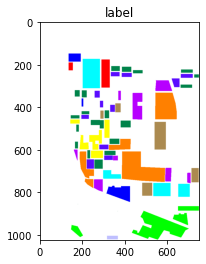

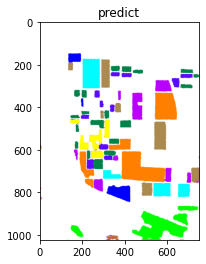

正确率: 0.9570390271493213


In [21]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
N_EPOCH=1000#训练次数
LR=0.1#初始学习率
GAMA=0.1#见LR_DECAY
LR_DECAY=[200,300,400,500,600]#学习率变化位置，即 第几个EPOCH进行学习率变化, 变化行为：学习率衰减为上一次的GAMA倍
BATCH_SIZE=16#学习批量
ONLY_TEST=True#如果设置为TRUE，则不进行训练，直接加载chekpoint中的最优模型进行测试
CUDA=False
ALLTEST=True#对整个图像进行测试 否则对测试集测试（测试集为随机划分）
ISRESUME=False
DATA_SIZE=100
AUG=1
def main():
    print("===> 建立模型")
    torch.set_grad_enabled(True)
    model=CNN(12) #模型
    model.apply(complex_weight_init)
    if ONLY_TEST or ISRESUME:
        model=torch.load("./checkpoint/model_best.pth",map_location= torch.device('cpu'))
        print("===> 加载模型成功")
    if CUDA:
        model=model.cuda()
    criterion=nn.CrossEntropyLoss() #损失函数reduction='sum'
    print("===> 加载数据集")
    full_dataset=Dataset("fle",size=DATA_SIZE,augment=AUG)
    train_set, val_set = torch.utils.data.random_split(full_dataset, [1100*AUG, 100*AUG])
    #train_set = Dataset()
    train_loader = DataLoader(dataset=train_set,num_workers=0,batch_size=BATCH_SIZE, shuffle=False)
    #val_set=Dataset(istrain=False)
    val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=BATCH_SIZE, shuffle=False)
    print("===> 设置 优化器")
    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = lr_scheduler.MultiStepLR(optimizer,LR_DECAY,gamma=GAMA)
    print("===> 进行训练")
    best_precision=0
    loss_plt=[]
    precision_plt=[]
    if not ONLY_TEST:
        for epoch in range(N_EPOCH):
            loss_sum = 0
            for i,batch in enumerate(train_loader):
                real, imag, label = batch[0], batch[1], batch[2]
                input = Complex(real, imag)
                if CUDA:
                    real=real.cuda()
                    imag=imag.cuda()
                    label=label.cuda()
                    input = Complex(real, imag)
                    input=input.cuda()
                optimizer.zero_grad()
                predict = model(input)
                loss = criterion(predict, label)
                loss.backward()
                optimizer.step()
                loss_sum+=loss.item()
                #print(i,loss.item())
            loss_plt.append(loss_sum)
            plot(loss_plt,"./loss.pdf","LOSS")
            print("Epoch:",epoch,"Loss:",loss_sum,"LR:",optimizer.param_groups[0]["lr"])
            scheduler.step()
            torch.set_grad_enabled(False)
            if ALLTEST:
                error_num=0
                sum=0
                input = Complex(full_dataset.data_real.unsqueeze(0), full_dataset.data_imag.unsqueeze(0))
                if CUDA:
                    input = Complex(full_dataset.data_real.unsqueeze(0).cuda(), full_dataset.data_imag.unsqueeze(0).cuda())
                    input=input.cuda()
                predict = model(input)
                max_id = torch.argmax(predict, 1)
                error_num_ = (full_dataset.label.unsqueeze(0) - max_id.cpu()).abs()
                error_num_[error_num_ > 0] = 1
                error_num += error_num_.sum()
                sum = full_dataset.label.shape[0] * full_dataset.label.shape[1]
                precision=(float(sum - error_num) / sum)
                print("Epoch:",epoch,"正确率:",precision)
                if precision>best_precision:
                    best_precision=precision
                    save_checkpoint(model,epoch)
                    plot_img(labeltoRGB(full_dataset.label.cpu()), "label")
                    plot_img(labeltoRGB(max_id[0].cpu()), "predict")
            else:
                error_num=0
                sum=0
                for batch in val_loader:
                    real, imag, label = batch[0], batch[1], batch[2]
                    input = Complex(real, imag)
                    if CUDA:
                        real = real.cuda()
                        imag = imag.cuda()
                        label = label.cuda()
                        input = Complex(real, imag)
                        input = input.cuda()
                    predict = model(input)
                    max_id = torch.argmax(predict, 1)
                    error_num_ = (label - max_id).abs()
                    error_num_[error_num_ > 0] = 1
                    error_num += error_num_.sum()
                    sum += label.shape[0] * label.shape[1] * label.shape[2]
                    #plot_img(labeltoRGB(label[0].cpu()), "label")
                    #plot_img(labeltoRGB(max_id[0].cpu()), "predict")
                precision=(float(sum - error_num) / sum)
                print("Epoch:",epoch,"正确率:",precision)
                if precision>best_precision:
                    best_precision=precision
                    save_checkpoint(model,epoch)
                    input = Complex(full_dataset.data_real.unsqueeze(0), full_dataset.data_imag.unsqueeze(0))
                    if CUDA:
                        input = Complex(full_dataset.data_real.unsqueeze(0).cuda(), full_dataset.data_imag.unsqueeze(0).cuda())
                        input=input.cuda()
                    predict = model(input)
                    max_id = torch.argmax(predict, 1)
                    plot_img(labeltoRGB(full_dataset.label.cpu()), "label")
                    plot_img(labeltoRGB(max_id[0].cpu()), "predict")
            precision_plt.append(precision)
            plot(precision_plt,"./precision.pdf","PRECISION")
            torch.set_grad_enabled(True)
    else:
        print("===> 跳过训练")
        torch.set_grad_enabled(False)
        error_num = 0
        sum = 0
        input = Complex(full_dataset.data_real.unsqueeze(0), full_dataset.data_imag.unsqueeze(0))
        if CUDA:
            input = Complex(full_dataset.data_real.unsqueeze(0).cuda(), full_dataset.data_imag.unsqueeze(0).cuda())
            input=input.cuda()
        predict = model(input)
        max_id = torch.argmax(predict, 1)
        max_id = torch.argmax(predict, 1)
        error_num_ = (full_dataset.label.unsqueeze(0) - max_id.cpu()).abs()
        error_num_[error_num_ > 0] = 1
        error_num += error_num_.sum()
        sum = full_dataset.label.shape[0] * full_dataset.label.shape[1]
        precision=(float(sum - error_num) / sum)
        print("正确率:",precision)
        plot_img(labeltoRGB(full_dataset.label.cpu()), "label")
        plot_img(labeltoRGB(max_id[0].cpu()), "predict")
        precision=(float(sum - error_num) / sum)
        if not ALLTEST:
            for batch in val_loader:
                real, imag, label = batch[0], batch[1], batch[2]
                input = Complex(real, imag)
                if CUDA:
                    real = real.cuda()
                    imag = imag.cuda()
                    label = label.cuda()
                    input = Complex(real, imag)
                    input = input.cuda()
                predict = model(input)
                max_id = torch.argmax(predict, 1)
                error_num_ = (label - max_id).abs()
                error_num_[error_num_ > 0] = 1
                error_num += error_num_.sum()
                sum += label.shape[0] * label.shape[1] * label.shape[2]
                #for i in range(label.shape[0]):
                    #plot_img(labeltoRGB(label[i].cpu()), "label")
                    #plot_img(labeltoRGB(max_id[i].cpu()), "predict")
            print("正确率:", (float(sum - error_num) / sum))
        torch.set_grad_enabled(True)
def save_checkpoint(model, epoch):
    if epoch % 10 == 0:
        model_out_path = "./checkpoint/" + "model_best.pth"
        if not os.path.exists("./checkpoint/"):
            os.makedirs("./checkpoint/")
        torch.save(model, model_out_path)
def plot(data,name="./loss.pdf",title="LOSS"):
    epoch=len(data)
    axis = np.linspace(1, epoch, epoch)
    label = title+' PICTURE'
    fig = plt.figure()
    plt.title(label)
    plt.plot(
        axis,
        data,
        label=title+'_EPOCH {}'.format(epoch)
    )
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel(title.lower())
    plt.grid(True)
    plt.savefig(name,dpi=200, bbox_inches='tight')
    plt.close(fig)
def labeltoRGB(label):
    RGB_list=[(255, 255, 255), (0, 0, 255), (255, 0, 0), (255, 255, 0), (0, 131, 74), (0, 255, 0), (183, 0, 255), (255, 128, 0),
     (90, 11, 255), (0, 252, 255), (171, 138, 80), (191, 191, 255), (255, 182, 229), (191, 255, 191), (255, 217, 157),
     (128, 0, 0)]
    img=np.empty([label.shape[0],label.shape[1],3],dtype=np.uint8)
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            img[i,j]=RGB_list[label[i][j]]
    img=Image.fromarray(img)
    return img
def plot_img(img,name):
    #plt.ion()
    img.save("./"+name+".jpeg")
    plt.figure(name)  # 图像窗口名称
    plt.imshow(img)
    plt.axis('on')  # 关掉坐标轴为 off
    plt.title(name)  # 图像题目
    plt.show()
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
if __name__ == "__main__":
    setup_seed(2)
    main()